### **Student Information**

Name: 毛柏毅

Student ID: 111062209

GitHub ID: Dogeon188

Kaggle name: Dogeon188

Kaggle private scoreboard snapshot:

![pic_ranking.png](./pics/pic_ranking.png)


# **Project Report**

---


## 1. Model Development (10 pts Required)


In [1]:
from dotenv import load_dotenv
from google import genai
from google.genai import types, errors
from pydantic import BaseModel, Field, ConfigDict
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import pickle
import os
from tqdm import tqdm
from pathlib import Path
import json
from typing import Literal


In [2]:
DATA_DIR = Path("./data/comp/")

# Load API key from .env file
env_path = "./config/.env"
load_dotenv(dotenv_path=env_path)

True

### 1.1 Preprocessing Steps

#### 1.1.1 Loading Data

First load the raw JSON data into a list of Post objects (validate with Pydantic). Each Post object contains the post ID, text, and hashtags.

In [27]:
with open(DATA_DIR / "final_posts.json", "r") as f:
    raw_posts = json.load(f)
print(f"Total number of posts: {len(raw_posts)}")

Total number of posts: 64171


In [28]:
class PostData(BaseModel):
    model_config = ConfigDict(extra='forbid')

    post_id: str
    text: str
    hashtags: list[str]


class PostSource(BaseModel):
    model_config = ConfigDict(extra='forbid')
    
    post: PostData


class PostRoot(BaseModel):
    model_config = ConfigDict(extra='forbid')
    
    post_type: Literal["post"] = Field(alias="_type")
    source: PostSource = Field(alias="_source")


class Post(BaseModel):
    model_config = ConfigDict(extra='forbid')
    
    root: PostRoot

In [29]:
def validate_post(post):
    try:
        validated_post = Post(**post)
        return validated_post
    except Exception as e:
        raise Exception(f"Validation error for post: {e}, {post}")

posts = list(map(validate_post, raw_posts))

In [30]:
posts[0].root.source.post

PostData(post_id='0x61fc95', text='We got the ranch, loaded our guns and sat up till sunrise.', hashtags=[])

Ensuring the data is correctly structured and validated, we can then convert this list into a pandas DataFrame for easier manipulation and analysis.

In [31]:
df_posts = pd.DataFrame([{
    "id": post.root.source.post.post_id,
    "text": post.root.source.post.text,
    "hashtags": post.root.source.post.hashtags
} for post in posts])

In [32]:
df_posts.head()

,id,text,hashtags
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[]
1,0x35663e,I bet there is an army of married couples who ...,[]
2,0xc78afe,This could only end badly.,[]
3,0x90089c,My sister squeezed a lime in her milk when she...,[]
4,0xaba820,and that got my head bobbing a little bit.,[]


There are still 3 more CSV files provided for this task:

- `data_identification.csv`: Contains the mapping between post IDs and their train/test split.
- `emotion.csv`: Contains the mapping between post IDs (train only) and their emotion labels.
- `samplesubmission.csv`: Contains the post IDs for the test set and a placeholder for predicted emotion labels. We don't need to handle this file in preprocessing.

In [33]:
df_identification = pd.read_csv(DATA_DIR / "data_identification.csv")
df_emotion = pd.read_csv(DATA_DIR / "emotion.csv")

df_merged = df_posts.merge(df_identification, on="id", how="left")
df_merged = df_merged.merge(df_emotion, on="id", how="left")

In [34]:
df_merged.head()

,id,text,hashtags,split,emotion
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[],test,NaN
1,0x35663e,I bet there is an army of married couples who ...,[],train,joy
2,0xc78afe,This could only end badly.,[],train,fear
3,0x90089c,My sister squeezed a lime in her milk when she...,[],train,joy
4,0xaba820,and that got my head bobbing a little bit.,[],test,NaN


#### 1.1.2 Data Exploration

Let's first see the label distribution in the dataset.

<Axes: title={'center': 'Distribution of Emotions in Dataset'}, xlabel='emotion'>

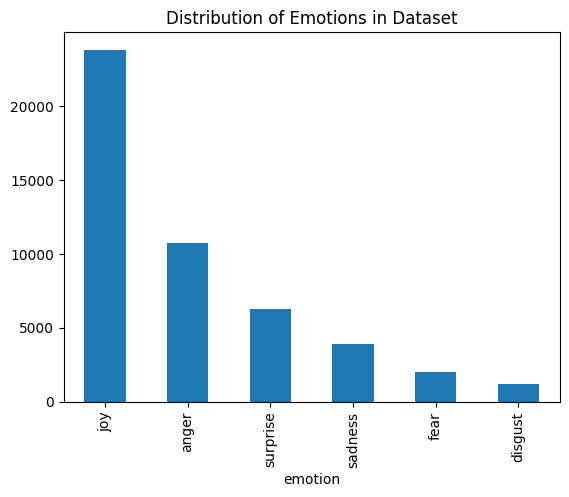

In [35]:
df_merged["emotion"].value_counts().plot(kind="bar", title="Distribution of Emotions in Dataset")

Seems quite imbalanced, with `joy` being the most frequent emotion and `disgust` the least.

The `hashtags` column contains lists of hashtags associated with each post. Let's explore the unique hashtags present in the dataset.

In [36]:
from collections import Counter

hashtag_counter = Counter()
for hashtags in df_merged['hashtags']:
    hashtag_counter.update(hashtags)

print(f"Unique hashtag count: {len(hashtag_counter)}")
print("Most common hashtags:")
for i, (tag, count) in enumerate(hashtag_counter.most_common(64)):
    print(f"{tag}({count})", end="")
    print("\t" if i % 8 != 7 else "\n", end="")

Unique hashtag count: 3403
Most common hashtags:
sad(73)	happy(73)	fear(62)	smile(61)	anxiety(58)	depression(58)	nervous(54)	musically(54)
angry(54)	terrorism(53)	hilarious(52)	awful(52)	blues(52)	sadness(51)	nightmare(51)	terrible(50)
lost(50)	shocking(48)	bitter(47)	gbbo(47)	optimism(47)	anger(45)	fuming(44)	terror(43)
horror(42)	rage(40)	bully(37)	revenge(37)	panic(36)	horrible(36)	sober(36)	quote(34)
bb18(32)	serious(32)	love(32)	1(31)	unhappy(31)	lively(31)	afraid(30)	depressing(29)
laughter(28)	offended(27)	start(27)	dark(26)	pakistan(25)	success(24)	glee(24)	snap(24)
life(23)	lol(23)	worry(23)	outrage(22)	trump(20)	excited(19)	funny(19)	india(19)
restless(17)	smiling(17)	faith(16)	music(16)	relentless(15)	snapchat(15)	cheer(14)	joy(14)


In [37]:
all_hashtags = list(hashtag_counter.keys())

There are many (thousands of) unique hashtags in the dataset. Fortunately for us, many frequent hashtags are related to emotions, such as `#sad`, `#happy`, `#fear`, etc. Perhaps we can leverage the word embeddings of these hashtags (aggregated in some way) as additional features for our model.

### 1.2 Feature Engineering Steps

#### 1.2.1 Gemini API Settings

Setting up the API client and model parameters.

In [40]:
# We input the API Key to be able to use the Gemini models
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key  # type: ignore
client = genai.Client(api_key=api_key)

To avoid hitting rate limits when making API calls, we can implement a rate-limiting decorator. It keeps track of the timestamps of recent calls and ensures we don't exceed the allowed number of calls per minute. This would be a more elegant solution than just adding fixed sleep intervals between calls.

[Check API Rate Limits](https://aistudio.google.com/usage?tab=rate-limit)

In [41]:
from queue import Queue
from time import time, sleep


def rate_limit_guard(rpm: int = 100, interval_sec: int = 60, wait_padding_sec: float = 0, verbose: bool = False):
    """A decorator to limit the rate of function calls.
    
    Args:
        rpm (int): Maximum number of calls allowed per interval.
        interval_sec (int): Time interval in seconds.
        wait_padding_sec (float): Additional padding time to wait in seconds.
        verbose (bool): If True, prints wait time when rate limit is exceeded.
    """
    def decorator(func):
        func.call_history = Queue()

        def wrapper(*args, **kwargs):
            current_time = time()
            while not func.call_history.empty():
                call_time = func.call_history.queue[0]
                if current_time - call_time > interval_sec:
                    func.call_history.get()
                else:
                    break
            if func.call_history.qsize() >= rpm:
                wait_time = interval_sec - \
                    (current_time - func.call_history.queue[0]) + wait_padding_sec
                if verbose:
                    print(
                        f"Rate limit exceeded. Waiting for {wait_time:.2f} seconds.")
                sleep(wait_time)
            func.call_history.put(time())
            return func(*args, **kwargs)
        return wrapper
    return decorator

In [42]:
embedding_models = [
    m.name.removeprefix("models/")
    for m in client.models.list()
    if m.supported_actions and 'embedContent' in m.supported_actions and m.name]
print("Available embedding models:")
for model in embedding_models:
    print(f"- {model}")

Available embedding models:
- embedding-001
- text-embedding-004
- gemini-embedding-exp-03-07
- gemini-embedding-exp
- gemini-embedding-001


In [43]:
# 100 requests per minute limit
@rate_limit_guard(rpm=100, interval_sec=60, wait_padding_sec=5)
def get_gemini_embeddings_one_batch(
    contents: list[str],
    model: str = "gemini-embedding-001"
) -> list[types.ContentEmbedding] | None:
    """Fetches the embedding for the given text using the specified Gemini model.
    """
    # if model not in embedding_models:
    #     raise ValueError(f"Model {model} is not available for embeddings.")
    # if len(contents) > 100:
    #     raise ValueError("Batch size exceeds the maximum limit of 100.")
    try:
        result = client.models.embed_content(model=model, contents=contents)
        return result.embeddings
    except errors.ClientError as e:
        if e.details["error"]["status"] == "RESOURCE_EXHAUSTED":
            print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
            sleep(5)  # Wait for 5 seconds before the next attempt
            return get_gemini_embeddings_one_batch(contents, model)  # Retry the request
        else:
            print("Unexpected ClientError:", e)
            return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    
def get_gemini_embeddings(
    contents: list[str],
    model: str = "gemini-embedding-001",
    batch_size: int = 100
) -> list[types.ContentEmbedding] | None:
    """Fetches embeddings for a list of contents in batches using the specified Gemini model.
    """
    if model not in embedding_models:
        raise ValueError(f"Model {model} is not available for embeddings.")
    if batch_size > 100:
        raise ValueError("Batch size exceeds the maximum limit of 100.")
    
    all_embeddings = []
    for i in tqdm(range(0, len(contents), batch_size), desc="Fetching embeddings in batches"):
        batch_contents = contents[i:i + batch_size]
        batch_embeddings = get_gemini_embeddings_one_batch(batch_contents, model)
        if batch_embeddings is None:
            print(f"Failed to get embeddings for batch starting at index {i}.")
            return None
        all_embeddings.extend(batch_embeddings)
    return all_embeddings


#### 1.2.2 Hashtag Embeddings

Let's first convert the hashtags into embeddings using the Gemini API.

In [20]:
hashtag_embeddings = get_gemini_embeddings(
    contents=all_hashtags,
    model="text-embedding-004"
)

Fetching embeddings in batches: 100%|██████████| 35/35 [00:42<00:00,  1.23s/it]


In [ ]:
hashtag_embeddings_dict = {
    tag: np.array(embedding.values)
    for tag, embedding in zip(all_hashtags, hashtag_embeddings)
}

In [37]:
# save embeddings to a pickle file
pickle.dump(hashtag_embeddings_dict, open(DATA_DIR / "hashtag_embeddings.pkl", "wb"))

In [45]:
hashtag_embeddings_dict = pickle.load(open(DATA_DIR / "hashtag_embeddings.pkl", "rb"))

Now let's visualize the distribution of these hashtag embeddings using 3D UMAP.

In [136]:
import umap
import plotly.express as px


def plot_umap(
    df: pd.DataFrame,
    label_col: str | None = None,
    hover_cols: list[str] | None = None,
    color_col: str | None = None,
    size_col: str | None = None,
    size_max: float | None = None,
    embedding_col: str = "embedding",
    kind: Literal["2d", "3d"] = "2d"
):

    reducer = umap.UMAP(n_components=3 if kind == "3d" else 2,
                        random_state=42, metric='cosine')
    embeddings = np.array(df[embedding_col].tolist())
    embeddings = reducer.fit_transform(embeddings)

    if kind == "2d":
        df_plot = df.copy()
        df_plot[['umap_x', 'umap_y']] = pd.DataFrame(
            embeddings, index=df.index)

        fig = px.scatter(
            df_plot,
            x='umap_x', y='umap_y',
            hover_data=hover_cols,
            text=label_col,
            color=color_col,
            size=size_col,
            title="2D UMAP of Hashtag Embeddings",
            width=800, height=600
        )
        if size_col is None and size_max is not None:
            fig.update_traces(marker=dict(size=size_max))
        fig.show()
    else:  # type == "3d"
        df_plot = df.copy()
        df_plot[['umap_x', 'umap_y', 'umap_z']] = pd.DataFrame(
            embeddings, index=df.index)

        fig = px.scatter_3d(
            df_plot,
            x='umap_x', y='umap_y', z='umap_z',
            hover_data=hover_cols,
            text=label_col,
            color=color_col,
            size=size_col,
            title="3D UMAP of Hashtag Embeddings",
            width=800, height=600
        )
        if size_col is None and size_max is not None:
            fig.update_traces(marker=dict(size=size_max))
        fig.show()

To better illustrate the discrimination between different hashtags, we first apply K-means clustering to group similar hashtags together, and then visualize the clusters in 3D UMAP space.

In [ ]:
from sklearn.cluster import KMeans


plot_df = pd.DataFrame({
    "hashtag": all_hashtags,
    "embedding": [hashtag_embeddings_dict[tag] for tag in all_hashtags]
})

# apply k-means clustering to group similar hashtags together

kmeans_hashtags = KMeans(n_clusters=10, random_state=42)
kmeans_hashtags.fit(np.array(plot_df["embedding"].tolist()))
plot_df["cluster"] = kmeans_hashtags.labels_
plot_df["dist"] = kmeans_hashtags.transform(
    np.array(plot_df["embedding"].tolist())
).min(axis=1)
plot_df["dist"] = plot_df["dist"].apply(
    lambda x: (x - plot_df["dist"].min()) / (plot_df["dist"].max() - plot_df["dist"].min())
)
plot_df["dist"] = plot_df["dist"].apply(lambda x: x ** 4)  # for better size discrimination
plot_df["cluster"] = plot_df["cluster"].astype(str)  # for better color mapping

In [109]:
for cluster_id in sorted(plot_df["cluster"].unique()):
    print(f"Cluster {cluster_id} representative hashtags:")
    top_tags = plot_df[plot_df["cluster"] == cluster_id].sort_values(
        by="dist", ascending=True).head(5)["hashtag"].tolist()
    print("\t", ", ".join(top_tags))

Cluster 0 representative hashtags:
	 notyet, nooneisalone, youvegottobekiddingme, usapleasedont, nothanks
Cluster 1 representative hashtags:
	 newyork, trump, hillaryclinton, nyc, boston
Cluster 2 representative hashtags:
	 news, video, religion, music, christianity
Cluster 3 representative hashtags:
	 stupidity, shitsucks, idiots, bullshit, losers
Cluster 4 representative hashtags:
	 twat, rawr, spooky, cat, dog
Cluster 5 representative hashtags:
	 selfimprovement, personaldevelopment, wisewords, selfhelp, tuesdaythought
Cluster 6 representative hashtags:
	 الخفجي, सत, アニメ, the, اليوم_الوطني
Cluster 7 representative hashtags:
	 getsauced, hellloooootwitter, rocktheretweet, getitgirl, loveisand
Cluster 8 representative hashtags:
	 joyful, happy, cheerful, joyous, wonderful
Cluster 9 representative hashtags:
	 sadness, distressed, sad, frustrated, saddened


In the above representative hashtags from each cluster, we can see some sense of emotions for each cluster, e.g. cluster 9 represents sadness, cluster 8 represents joy, and cluster 2 are neutral hashtags.

In [142]:
plot_umap(
    df=plot_df,
    hover_cols=["hashtag"],
    color_col="cluster",
    size_col="dist",
    kind="3d"
)

/home/dogeon/dm-2025/lab2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Unfortunately, there seems no clear boundary between different clusters in the UMAP plot. Perhaps this is because the word embeddings of hashtags are already highly compressed representations, and further dimensionality reduction with UMAP may lose some important information. Nevertheless, we will still attempt to use these hashtag embeddings as additional features for our model.

For now, we can aggregate the hashtag embeddings for each post by taking the mean of the embeddings of all hashtags associated with that post. If there are no hashtags, we can use a zero vector as the embedding.

In [167]:
def aggregate_hashtag_embeddings(
    hashtags: list[str],
    embedding_dict: dict[str, np.ndarray],
    embedding_dim: int = 768
) -> np.ndarray:
    if not hashtags:
        return np.zeros(embedding_dim)

    # Get the embeddings for the hashtags
    embeddings = [embedding_dict.get(tag, np.zeros(embedding_dim)) for tag in hashtags]
    # Return the mean of the embeddings
    return np.mean(embeddings, axis=0)

df_merged["hashtag_embedding"] = df_merged["hashtags"].apply(
    lambda tags: aggregate_hashtag_embeddings(
        tags,
        hashtag_embeddings_dict,
        embedding_dim=len(next(iter(hashtag_embeddings_dict.values())))
    )
)

In [168]:
df_merged[df_merged["hashtags"].apply(len) > 0][["hashtags", "hashtag_embedding"]].head()

,hashtags,hashtag_embedding
14,"[badd, wicked, bright]","[-0.047749574999999995, -0.012394224333333334,..."
41,"[lifechanging, sad, happy, emotionalrollercoas...","[0.022812601874999998, -0.031855646975, 0.0199..."
55,"[sad, nevertrump]","[0.0243623165, -0.0380359135, 0.00335818199999..."
60,[nevertrump],"[0.030582117, -0.05871542, -0.042564586, -0.03..."
61,"[nervous, excited]","[0.017024095, -0.043110255, 0.0310002935, 0.01..."


#### 1.2.3 Post Text Embeddings

Similarly, we'll convert the post texts into embeddings using the Gemini API.

In [ ]:
text_embeddings = get_gemini_embeddings(
    contents=df_merged["text"].tolist(),
    model="text-embedding-004"
)

In [112]:
df_merged["text_embedding"] = [np.array(embedding.values) for embedding in text_embeddings]

In [169]:
df_merged.to_pickle(DATA_DIR / "df_merged_with_text_embeddings.pkl")


In [170]:
df_merged = pd.read_pickle(DATA_DIR / "df_merged_with_text_embeddings.pkl")

In [171]:
df_merged.head()

,id,text,hashtags,split,emotion,text_embedding,hashtag_embedding
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[],test,NaN,"[0.0074587376, 0.0094784545, 0.0024528992, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0x35663e,I bet there is an army of married couples who ...,[],train,joy,"[-0.01895659, 0.00072769175, -0.00050007005, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0xc78afe,This could only end badly.,[],train,fear,"[0.01238031, -0.00046374192, 0.004575007, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0x90089c,My sister squeezed a lime in her milk when she...,[],train,joy,"[0.012005463, 0.007308754, -0.055489037, 0.060...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0xaba820,and that got my head bobbing a little bit.,[],test,NaN,"[0.028398054, -0.043395437, -0.014858938, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [166]:
plot_umap(
    df=df_merged[df_merged["split"] == "train"].sample(n=3000, random_state=42),
    embedding_col="text_embedding",
    hover_cols=["text", "hashtags"],
    color_col="emotion",
    size_max=4,
    kind="3d"
)

/home/dogeon/dm-2025/lab2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Similar to the observation with hashtag embeddings, the UMAP plot of text embeddings also shows no clear cluster boundaries. We can only see vague boundary among part of `joy` emotions, but other emotions are quite mixed together.

This could be due to the same reason mentioned earlier - the text embeddings are already compressed representations, and further dimensionality reduction may lose important information.

### 1.3 Model Implementation

#### 1.3.1 Train Test Split

In [172]:
df_train = df_merged[df_merged['split'] == 'train'].reset_index(drop=True)
df_test = df_merged[df_merged['split'] == 'test'].reset_index(drop=True)

In [175]:
df_train.to_pickle(DATA_DIR / "df_train_final.pkl")
df_test.to_pickle(DATA_DIR / "df_test_final.pkl")

In [3]:
df_train = pd.read_pickle(DATA_DIR / "df_train_final.pkl")
df_test = pd.read_pickle(DATA_DIR / "df_test_final.pkl")

In [4]:
print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

Training set size: 47890
Test set size: 16281


In [5]:
df_train.head()

,id,text,hashtags,split,emotion,text_embedding,hashtag_embedding
0,0x35663e,I bet there is an army of married couples who ...,[],train,joy,"[-0.01895659, 0.00072769175, -0.00050007005, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0xc78afe,This could only end badly.,[],train,fear,"[0.01238031, -0.00046374192, 0.004575007, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0x90089c,My sister squeezed a lime in her milk when she...,[],train,joy,"[0.012005463, 0.007308754, -0.055489037, 0.060...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0x2ffb63,Thank you so much❤️,[],train,joy,"[-0.0032902658, -0.015828965, 0.002385771, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0x989146,Stinks because ive been in this program for a ...,[],train,joy,"[0.057019755, -0.02723884, 0.008149491, 0.0590...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### 1.3.2 DataLoader Preparation

In [6]:
# split train into train and val
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train["emotion"]
)

In [69]:
emotion_labels = sorted(df_train["emotion"].unique())
label_to_idx = {label: idx for idx, label in enumerate(emotion_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
print("Label to Index mapping:")
for label, idx in label_to_idx.items():
    print(f"{label}: {idx}")

Label to Index mapping:
anger: 0
disgust: 1
fear: 2
joy: 3
sadness: 4
surprise: 5


In [8]:
class EmotionDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text_embedding = torch.tensor(row["text_embedding"], dtype=torch.float32)
        hashtag_embedding = torch.tensor(
            row["hashtag_embedding"], dtype=torch.float32)
        label = torch.tensor(label_to_idx[row["emotion"]], dtype=torch.long)
        return text_embedding, hashtag_embedding, label

In [9]:
loader_batch_size = 32

In [10]:
dataset_train = EmotionDataset(df_train)
train_loader = DataLoader(dataset_train, batch_size=loader_batch_size, shuffle=True)

dataset_val = EmotionDataset(df_val)
val_loader = DataLoader(dataset_val, batch_size=loader_batch_size, shuffle=False)

#### 1.3.2 Model Training

In [ ]:
class ClassifierModel(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, dropout_rate: float = 0.5):
        super(ClassifierModel, self).__init__()
        self.net_text = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(hidden_dim, output_dim)
        )
        self.net_tag = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(hidden_dim, output_dim)
        )
        self.weights_text = torch.nn.Parameter(torch.tensor(0.5))
        self.weights_tag = torch.nn.Parameter(torch.tensor(0.5))

        # init with xavier uniform
        for layer in self.net_text:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
        for layer in self.net_tag:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x_text, x_tag):
        out_text = self.net_text(x_text)
        out_tag = self.net_tag(x_tag)
        out = out_text * self.weights_text + out_tag * self.weights_tag
        return out


In [62]:
from sklearn.metrics import f1_score


def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion,
    optimizer,
    num_epochs: int = 25,
    device: str = 'cpu'
):
    val_labels = []
    for _, _, labels in val_loader:
        val_labels.extend(labels.numpy())

    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_means = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for text_emb, tag_emb, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", total=len(train_loader)):
            text_emb, tag_emb, labels = text_emb.to(device), tag_emb.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(text_emb, tag_emb)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * text_emb.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        correct_predictions = 0
        all_preds = []
        with torch.no_grad():
            for text_emb, tag_emb, labels in tqdm(val_loader, desc="Validation", total=len(val_loader)):
                text_emb, tag_emb, labels = text_emb.to(device), tag_emb.to(device), labels.to(device)
                outputs = model(text_emb, tag_emb)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * text_emb.size(0)

                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)

                all_preds.append(preds)
        
        all_preds = torch.cat(all_preds).cpu().numpy()
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = correct_predictions.double() / len(val_loader.dataset)
        val_f1_mean = f1_score(val_labels, all_preds, average='weighted')

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy.item())
        val_f1_means.append(val_f1_mean)

        print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}, Mean F1: {val_f1_mean:.4f}')

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_f1_means": val_f1_means
    }

In [55]:
model = ClassifierModel(input_dim=768, hidden_dim=256, output_dim=len(df_train["emotion"].unique()), dropout_rate=0.5)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
train_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device='cuda'
)

Epoch 1/25: 100%|██████████| 1198/1198 [00:01<00:00, 678.81it/s]


Epoch 1/25, Training Loss: 0.4041


Validation: 100%|██████████| 300/300 [00:00<00:00, 1275.56it/s]


Validation Loss: 1.5646, Accuracy: 0.6392, Mean F1: 0.6262


Epoch 2/25: 100%|██████████| 1198/1198 [00:01<00:00, 795.11it/s]


Epoch 2/25, Training Loss: 0.3925


Validation: 100%|██████████| 300/300 [00:00<00:00, 1273.79it/s]


Validation Loss: 1.5570, Accuracy: 0.6338, Mean F1: 0.6233


Epoch 3/25: 100%|██████████| 1198/1198 [00:01<00:00, 783.48it/s]


Epoch 3/25, Training Loss: 0.3825


Validation: 100%|██████████| 300/300 [00:00<00:00, 1345.46it/s]


Validation Loss: 1.6064, Accuracy: 0.6372, Mean F1: 0.6220


Epoch 4/25: 100%|██████████| 1198/1198 [00:01<00:00, 678.55it/s]


Epoch 4/25, Training Loss: 0.3858


Validation: 100%|██████████| 300/300 [00:00<00:00, 1360.30it/s]


Validation Loss: 1.6338, Accuracy: 0.6361, Mean F1: 0.6208


Epoch 5/25: 100%|██████████| 1198/1198 [00:01<00:00, 652.60it/s]


Epoch 5/25, Training Loss: 0.3763


Validation: 100%|██████████| 300/300 [00:00<00:00, 1352.16it/s]


Validation Loss: 1.6210, Accuracy: 0.6353, Mean F1: 0.6246


Epoch 6/25: 100%|██████████| 1198/1198 [00:01<00:00, 690.72it/s]


Epoch 6/25, Training Loss: 0.3733


Validation: 100%|██████████| 300/300 [00:00<00:00, 1332.74it/s]


Validation Loss: 1.6555, Accuracy: 0.6371, Mean F1: 0.6229


Epoch 7/25: 100%|██████████| 1198/1198 [00:01<00:00, 695.32it/s]


Epoch 7/25, Training Loss: 0.3651


Validation: 100%|██████████| 300/300 [00:00<00:00, 1324.64it/s]


Validation Loss: 1.6596, Accuracy: 0.6325, Mean F1: 0.6211


Epoch 8/25: 100%|██████████| 1198/1198 [00:01<00:00, 683.41it/s]


Epoch 8/25, Training Loss: 0.3609


Validation: 100%|██████████| 300/300 [00:00<00:00, 1333.42it/s]


Validation Loss: 1.6406, Accuracy: 0.6306, Mean F1: 0.6178


Epoch 9/25: 100%|██████████| 1198/1198 [00:01<00:00, 691.54it/s]


Epoch 9/25, Training Loss: 0.3529


Validation: 100%|██████████| 300/300 [00:00<00:00, 1322.38it/s]


Validation Loss: 1.7817, Accuracy: 0.6311, Mean F1: 0.6187


Epoch 10/25: 100%|██████████| 1198/1198 [00:01<00:00, 641.57it/s]


Epoch 10/25, Training Loss: 0.3469


Validation: 100%|██████████| 300/300 [00:00<00:00, 1318.59it/s]


Validation Loss: 1.7362, Accuracy: 0.6348, Mean F1: 0.6232


Epoch 11/25: 100%|██████████| 1198/1198 [00:01<00:00, 666.05it/s]


Epoch 11/25, Training Loss: 0.3511


Validation: 100%|██████████| 300/300 [00:00<00:00, 1339.16it/s]


Validation Loss: 1.7795, Accuracy: 0.6365, Mean F1: 0.6238


Epoch 12/25: 100%|██████████| 1198/1198 [00:01<00:00, 650.91it/s]


Epoch 12/25, Training Loss: 0.3404


Validation: 100%|██████████| 300/300 [00:00<00:00, 1329.81it/s]


Validation Loss: 1.8060, Accuracy: 0.6345, Mean F1: 0.6218


Epoch 13/25: 100%|██████████| 1198/1198 [00:01<00:00, 708.25it/s]


Epoch 13/25, Training Loss: 0.3350


Validation: 100%|██████████| 300/300 [00:00<00:00, 1339.97it/s]


Validation Loss: 1.8139, Accuracy: 0.6335, Mean F1: 0.6188


Epoch 14/25: 100%|██████████| 1198/1198 [00:01<00:00, 693.92it/s]


Epoch 14/25, Training Loss: 0.3300


Validation: 100%|██████████| 300/300 [00:00<00:00, 1325.57it/s]


Validation Loss: 1.8798, Accuracy: 0.6379, Mean F1: 0.6213


Epoch 15/25: 100%|██████████| 1198/1198 [00:01<00:00, 667.88it/s]


Epoch 15/25, Training Loss: 0.3280


Validation: 100%|██████████| 300/300 [00:00<00:00, 1283.49it/s]


Validation Loss: 1.8599, Accuracy: 0.6348, Mean F1: 0.6204


Epoch 16/25: 100%|██████████| 1198/1198 [00:01<00:00, 790.08it/s]


Epoch 16/25, Training Loss: 0.3258


Validation: 100%|██████████| 300/300 [00:00<00:00, 1280.11it/s]


Validation Loss: 1.8729, Accuracy: 0.6324, Mean F1: 0.6192


Epoch 17/25: 100%|██████████| 1198/1198 [00:01<00:00, 789.80it/s]


Epoch 17/25, Training Loss: 0.3196


Validation: 100%|██████████| 300/300 [00:00<00:00, 1346.44it/s]


Validation Loss: 1.8899, Accuracy: 0.6353, Mean F1: 0.6221


Epoch 18/25: 100%|██████████| 1198/1198 [00:01<00:00, 699.91it/s]


Epoch 18/25, Training Loss: 0.3216


Validation: 100%|██████████| 300/300 [00:00<00:00, 1327.09it/s]


Validation Loss: 1.8933, Accuracy: 0.6343, Mean F1: 0.6196


Epoch 19/25: 100%|██████████| 1198/1198 [00:01<00:00, 658.52it/s]


Epoch 19/25, Training Loss: 0.3118


Validation: 100%|██████████| 300/300 [00:00<00:00, 1350.60it/s]


Validation Loss: 1.9268, Accuracy: 0.6354, Mean F1: 0.6217


Epoch 20/25: 100%|██████████| 1198/1198 [00:01<00:00, 675.63it/s]


Epoch 20/25, Training Loss: 0.3111


Validation: 100%|██████████| 300/300 [00:00<00:00, 1326.64it/s]


Validation Loss: 1.9976, Accuracy: 0.6354, Mean F1: 0.6199


Epoch 21/25: 100%|██████████| 1198/1198 [00:01<00:00, 648.99it/s]


Epoch 21/25, Training Loss: 0.3109


Validation: 100%|██████████| 300/300 [00:00<00:00, 1347.03it/s]


Validation Loss: 1.9977, Accuracy: 0.6338, Mean F1: 0.6233


Epoch 22/25: 100%|██████████| 1198/1198 [00:01<00:00, 679.43it/s]


Epoch 22/25, Training Loss: 0.3039


Validation: 100%|██████████| 300/300 [00:00<00:00, 1343.77it/s]


Validation Loss: 2.0236, Accuracy: 0.6345, Mean F1: 0.6185


Epoch 23/25: 100%|██████████| 1198/1198 [00:01<00:00, 653.91it/s]


Epoch 23/25, Training Loss: 0.3003


Validation: 100%|██████████| 300/300 [00:00<00:00, 1332.17it/s]


Validation Loss: 2.0739, Accuracy: 0.6309, Mean F1: 0.6179


Epoch 24/25: 100%|██████████| 1198/1198 [00:01<00:00, 639.49it/s]


Epoch 24/25, Training Loss: 0.2988


Validation: 100%|██████████| 300/300 [00:00<00:00, 1351.62it/s]


Validation Loss: 2.0440, Accuracy: 0.6310, Mean F1: 0.6165


Epoch 25/25: 100%|██████████| 1198/1198 [00:01<00:00, 669.38it/s]


Epoch 25/25, Training Loss: 0.2989


Validation: 100%|██████████| 300/300 [00:00<00:00, 1329.39it/s]

Validation Loss: 2.0193, Accuracy: 0.6336, Mean F1: 0.6188


In [64]:
print(f"Final Weights - Text: {model.weights_text.item():.4f}, Hashtag: {model.weights_tag.item():.4f}")

Final Weights - Text: 5.7326, Hashtag: 0.9851


<Axes: >

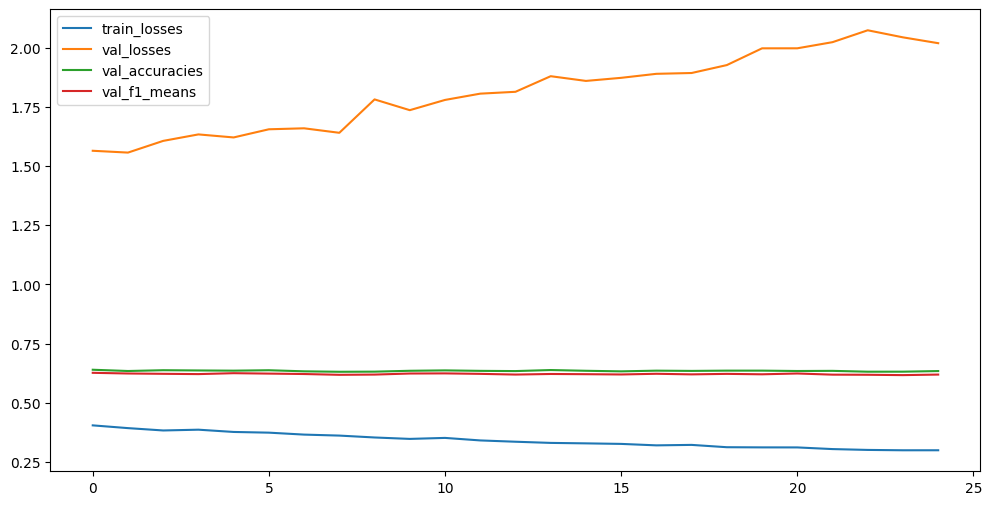

In [65]:
pd.DataFrame(train_history).plot(figsize=(12, 6))

Evaluating on Validation Set: 100%|██████████| 300/300 [00:00<00:00, 1410.32it/s]


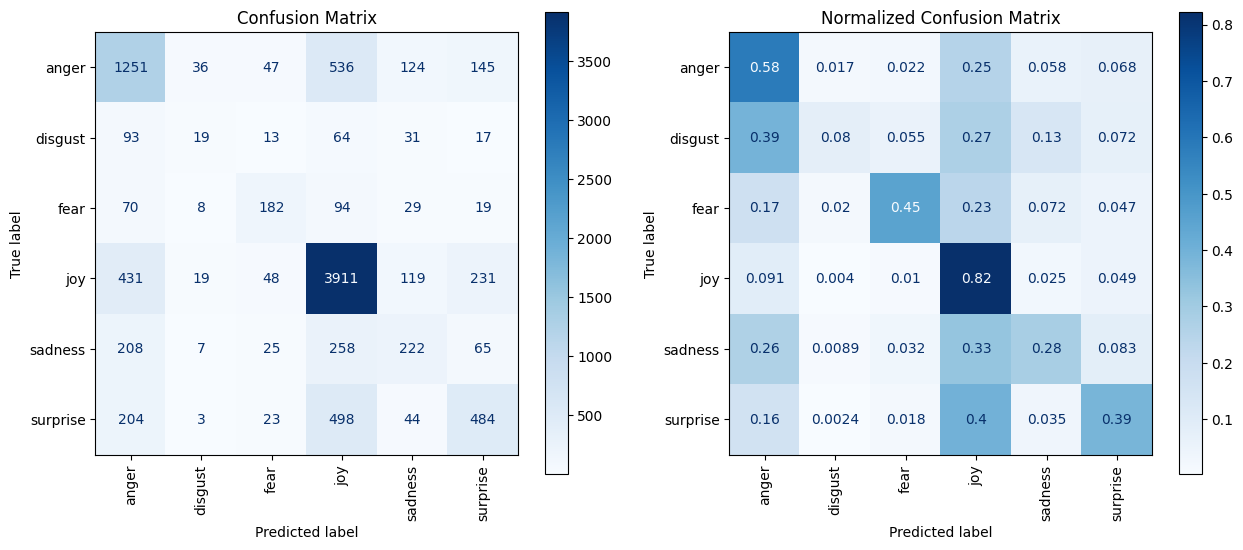

In [71]:
# plot the confusion matrix on the val set
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for text_emb, tag_emb, labels in tqdm(val_loader, desc="Evaluating on Validation Set", total=len(val_loader)):
        text_emb, tag_emb = text_emb.to('cuda'), tag_emb.to('cuda')
        outputs = model(text_emb, tag_emb)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=emotion_labels)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax[0])
disp_norm.plot(cmap='Blues', xticks_rotation='vertical', ax=ax[1])

ax[0].set_title("Confusion Matrix")
ax[1].set_title("Normalized Confusion Matrix")

plt.show()

#### 1.3.3 Prediction on Test Set

In [ ]:
# Evaluate on Test Set
all_test_preds = []

for row in tqdm(df_test.itertuples(), total=len(df_test), desc="Evaluating on Test Set"):
    text_emb = torch.tensor(row.text_embedding, dtype=torch.float32).unsqueeze(0).to('cuda')
    tag_emb = torch.tensor(row.hashtag_embedding, dtype=torch.float32).unsqueeze(0).to('cuda')

    with torch.no_grad():
        outputs = model(text_emb, tag_emb)
        _, pred = torch.max(outputs, 1)

    all_test_preds.append(pred.cpu().item())

Evaluating on Test Set: 100%|██████████| 16281/16281 [00:01<00:00, 12368.66it/s]


In [ ]:
df_test['predicted_emotion'] = [idx_to_label[idx] for idx in all_test_preds]
df_test[['id', 'predicted_emotion']].head()

,id,predicted_emotion
0,0x61fc95,joy
1,0xaba820,joy
2,0x66e44d,joy
3,0xc03cf5,joy
4,0x02f65a,anger


In [ ]:
df_test[["id", "predicted_emotion"]].to_csv(DATA_DIR / "test_set_predictions.csv", index=False)

In [ ]:
!kaggle competitions submit -c dm-lab-2-private-competition -f ./data${DATA_DIR / "test_set_predictions.csv"} -m "Test set predictions from Gemini embedding + PyTorch classifier"

100%|█████████████████████████████████████████| 228k/228k [00:01<00:00, 183kB/s]
Successfully submitted to DM Lab 2 Private Competition

---

## 2. Bonus Section (5 pts Optional)

### 2.1 Mention Different Things You Tried

### 2.2 Mention Insights You Gained

---